## Outlier Detection methodology

Author: Severin Boussie

## 1. Time Serie import

1st step is to import financial quarterly time series

In [1]:
import pandas as pd
import numpy as np
import matplotlib
from sklearn.manifold import TSNE
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

In [2]:
df = pd.read_csv('time_series.csv')
df.head()

desc                         indicator  \
0  The Bank of New York Mellon Corporation           Capital Adequacy Ratio1   
1  The Bank of New York Mellon Corporation           Capital Adequacy Ratio2   
2  The Bank of New York Mellon Corporation  Cash coverage of NPLs (LLR/NPL)1   
3  The Bank of New York Mellon Corporation  Cash coverage of NPLs (LLR/NPL)2   
4  The Bank of New York Mellon Corporation  Cash coverage of NPLs (LLR/NPL)3   

    3/31/2010  5/31/2010  6/30/2010  8/31/2010   9/30/2010  11/30/2010  \
0   17.190000        NaN      17.21        NaN   15.760000         NaN   
1   17.190000        NaN      17.22        NaN   15.770000         NaN   
2  114.537445        NaN     135.50        NaN  132.835821         NaN   
3  114.537445        NaN     135.50        NaN  132.835821         NaN   
4   68.420000        NaN      79.36        NaN   68.110000         NaN   

   12/31/2010  2/28/2011  ...  10/31/2018  11/30/2018  12/31/2018  1/31/2019  \
0       16.32        NaN  ...         NaN         NaN    13.57000        NaN   
1       16.33        NaN  ...         NaN         NaN    13.57000        NaN   
2      124.50        NaN  ...         NaN         NaN   129.20354        NaN   
3      124.50        NaN  ...         NaN         NaN   129.20354        NaN   
4       66.05        NaN  ...         NaN         NaN   132.73000        NaN   

   2/28/2019  3/31/2019  4/30/2019  5/31/2019  6/30/2019  9/30/2019  
0        NaN  14.020000        NaN        NaN       14.0        NaN  
1        NaN  14.020000        NaN        NaN        NaN        NaN  
2        NaN  70.192308        NaN        NaN        NaN        NaN  
3        NaN  70.192308        NaN        NaN        NaN        NaN  
4        NaN  71.220000        NaN        NaN        NaN        NaN  

[5 rows x 97 columns]

In [3]:
flat_df = df.set_index(['desc','indicator']).stack().reset_index()
flat_df.head()

desc                indicator  \
0  The Bank of New York Mellon Corporation  Capital Adequacy Ratio1   
1  The Bank of New York Mellon Corporation  Capital Adequacy Ratio1   
2  The Bank of New York Mellon Corporation  Capital Adequacy Ratio1   
3  The Bank of New York Mellon Corporation  Capital Adequacy Ratio1   
4  The Bank of New York Mellon Corporation  Capital Adequacy Ratio1   

      level_2      0  
0   3/31/2010  17.19  
1   6/30/2010  17.21  
2   9/30/2010  15.76  
3  12/31/2010  16.32  
4   3/31/2011  16.76

In [4]:
# construct a table which takes mean of the same indicator value on the same date
df_vec= pd.pivot_table(flat_df,index=['desc','level_2'],columns ='indicator',values= 0,aggfunc=np.mean).reset_index()
df_vec.head()
#len(df_vec)

indicator                 desc     level_2  Capital Adequacy Ratio1  \
0          ABN AMRO Group N.V.  12/31/2010                16.621965   
1          ABN AMRO Group N.V.  12/31/2011                16.787278   
2          ABN AMRO Group N.V.  12/31/2012                18.435304   
3          ABN AMRO Group N.V.  12/31/2013                20.178512   
4          ABN AMRO Group N.V.  12/31/2014                19.743303   

indicator  Capital Adequacy Ratio2  Cash coverage of NPLs (LLR/NPL)1  \
0                              NaN                         66.326215   
1                              NaN                         63.601797   
2                              NaN                         54.423381   
3                              NaN                         53.294055   
4                              NaN                               NaN   

indicator  Cash coverage of NPLs (LLR/NPL)2  Cash coverage of NPLs (LLR/NPL)3  \
0                                 66.326215                               NaN   
1                                 63.601797                               NaN   
2                                 54.423381                               NaN   
3                                 53.294055                               NaN   
4                                       NaN                               NaN   

indicator  Credit risk RWA  Fully Loaded CET1 (%)1  Fully Loaded CET1 (%)2  \
0              133525980.6               10.387869                     NaN   
1              132002598.2               10.656375                     NaN   
2              132381831.4               12.098168                     NaN   
3              118709633.0               14.400250                     NaN   
4              106115112.3               14.068675                     NaN   

indicator  ...   NSFR   Net Income1  Net Income2  Operational risk RWA  \
0          ...    NaN -1.273885e+05          NaN           19391216.90   
1          ...  100.0  4.601494e+05          NaN           16901591.43   
2          ...  108.0  9.717186e+05          NaN           20384995.71   
3          ...  105.0  1.040006e+06          NaN           22605522.28   
4          ...    NaN  1.109968e+06          NaN           19570295.95   

indicator  Provisions /Avg. Amortized Loans     ROAA1  ROAA2     ROAE1  ROAE2  \
0                                  0.327447  0.035946    NaN  0.967206    NaN   
1                                  0.379454  0.062759    NaN  1.943602    NaN   
2                                  0.589844  0.183997    NaN  5.909793    NaN   
3                                  0.670902  0.199639    NaN  5.886877    NaN   
4                                  0.394346  0.330842    NaN  9.157047    NaN   

indicator          SLR  
0                  NaN  
1                  NaN  
2                  NaN  
3          608612545.6  
4          509969133.9  

[5 rows x 30 columns]

## 2. Data Subset selection

From here we select the data for which we have enough data points.

In [5]:
# find out how many NA in each feature
list_feat= df_vec.apply(pd.isna).sum(axis=0)
list_feat

indicator
desc                                                   0
level_2                                                0
Capital Adequacy Ratio1                              322
Capital Adequacy Ratio2                             2004
Cash coverage of NPLs (LLR/NPL)1                     989
Cash coverage of NPLs (LLR/NPL)2                     989
Cash coverage of NPLs (LLR/NPL)3                    2001
Credit risk RWA                                     1065
Fully Loaded CET1 (%)1                               327
Fully Loaded CET1 (%)2                              1990
Impaired Loans (NPLs) %1                             683
Impaired Loans (NPLs) %2                             997
Impaired Loans (NPLs) %3                            1978
LCR                                                 1692
Loan Impairment Charges / Avg Gross Loans (bps)1    1050
Loan Impairment Charges / Avg Gross Loans (bps)2    1978
Loan Impairment Charges / Avg Gross Loans (bps)3    1096
Loans-to-Deposits1   

In [6]:
feats_t = list(list_feat[list_feat<500].index)
if 'Net Income1' in feats_t: feats_t.remove('Net Income1')
if 'ROAE1' in feats_t: feats_t.remove('ROAE1')
print('Selected Features',feats_t)
df_vec2 = df_vec[feats_t].dropna()
feats = feats_t[2:]
len(df_vec2)

Selected Features ['desc', 'level_2', 'Capital Adequacy Ratio1', 'Fully Loaded CET1 (%)1', 'ROAA1']


2252

In [7]:
# change into quarters since 2010
df_vec2['idx']=df_vec2['level_2'].map(lambda x : (int(x.split('/')[2])-2010)*4+int(x.split('/')[0])/3-1)
df_vec2.head()

indicator                 desc     level_2  Capital Adequacy Ratio1  \
0          ABN AMRO Group N.V.  12/31/2010                16.621965   
1          ABN AMRO Group N.V.  12/31/2011                16.787278   
2          ABN AMRO Group N.V.  12/31/2012                18.435304   
3          ABN AMRO Group N.V.  12/31/2013                20.178512   
4          ABN AMRO Group N.V.  12/31/2014                19.743303   

indicator  Fully Loaded CET1 (%)1     ROAA1   idx  
0                       10.387869  0.035946   3.0  
1                       10.656375  0.062759   7.0  
2                       12.098168  0.183997  11.0  
3                       14.400250  0.199639  15.0  
4                       14.068675  0.330842  19.0

## 3. Quarter-to-quarter variations computation

For each indicator, we compute the quarter to quarter variation.

In [8]:
groups = df_vec2.groupby('desc')
groups.head()

indicator                   desc     level_2  Capital Adequacy Ratio1  \
0            ABN AMRO Group N.V.  12/31/2010                16.621965   
1            ABN AMRO Group N.V.  12/31/2011                16.787278   
2            ABN AMRO Group N.V.  12/31/2012                18.435304   
3            ABN AMRO Group N.V.  12/31/2013                20.178512   
4            ABN AMRO Group N.V.  12/31/2014                19.743303   
...                          ...         ...                      ...   
2590       Wells Fargo & Company  12/31/2010                15.010000   
2591       Wells Fargo & Company  12/31/2011                14.220000   
2592       Wells Fargo & Company  12/31/2012                14.630000   
2593       Wells Fargo & Company  12/31/2013                15.430000   
2594       Wells Fargo & Company  12/31/2014                15.530000   

indicator  Fully Loaded CET1 (%)1     ROAA1   idx  
0                       10.387869  0.035946   3.0  
1                       10.656375  0.062759   7.0  
2                       12.098168  0.183997  11.0  
3                       14.400250  0.199639  15.0  
4                       14.068675  0.330842  19.0  
...                           ...       ...   ...  
2590                     8.300000  1.067946   3.0  
2591                     8.990000  1.280586   7.0  
2592                    10.120000  1.471233  11.0  
2593                    10.820000  1.533491  15.0  
2594                    11.040000  1.453484  19.0  

[380 rows x 6 columns]

In [9]:
output = []
for key,group in groups:
    sort_df =group.sort_values('idx')
    for feat in feats:
        sort_df[feat+'T1']=sort_df[feat].shift(1)
        sort_df[feat+'_rel']=sort_df.apply(lambda row : (row[feat]-row[feat+'T1'])/row[feat+'T1'] if abs(row[feat])>0.1 else None,axis=1)
    output.append(sort_df)
    
df_train = pd.concat(output).dropna().reset_index().drop(['index'],axis=1)
df_train.head()

indicator                 desc    level_2  Capital Adequacy Ratio1  \
0          ABN AMRO Group N.V.  3/31/2011                17.869579   
1          ABN AMRO Group N.V.  6/30/2011                18.151743   
2          ABN AMRO Group N.V.  9/30/2011                17.382323   
3          ABN AMRO Group N.V.  3/31/2012                16.508374   
4          ABN AMRO Group N.V.  6/30/2012                16.213218   

indicator  Fully Loaded CET1 (%)1     ROAA1  idx  Capital Adequacy Ratio1T1  \
0                       11.351277  0.564036  4.0                  16.621965   
1                       11.415061  0.397196  5.0                  17.869579   
2                       10.857577  0.160774  6.0                  18.151743   
3                       10.621552  0.348426  8.0                  16.787278   
4                       11.852388  0.285924  9.0                  16.508374   

indicator  Capital Adequacy Ratio1_rel  Fully Loaded CET1 (%)1T1  \
0                             0.075058                 10.387869   
1                             0.015790                 11.351277   
2                            -0.042388                 11.415061   
3                            -0.016614                 10.656375   
4                            -0.017879                 10.621552   

indicator  Fully Loaded CET1 (%)1_rel   ROAA1T1  ROAA1_rel  
0                            0.092744  0.035946  14.691255  
1                            0.005619  0.564036  -0.295797  
2                           -0.048838  0.397196  -0.595228  
3                           -0.003268  0.062759   4.551824  
4                            0.115881  0.348426  -0.179386

We use the t-SNE to reduce dimensionality and vizualize the vectors
See discussion of t-SNE [here](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

In [10]:
data= df_train[[feat for feat in feats]].values
tsne_model = TSNE(perplexity=30, n_components=2, init='pca', n_iter=1000)
new_values = tsne_model.fit_transform(data)
df_train[['x','y']]=pd.DataFrame(new_values)

# Dimensionality Reduction algo for vizualization
data= df_train[[feat+'_rel' for feat in feats]].values
tsne_model = TSNE(perplexity=30, n_components=2, init='pca', n_iter=1000)
new_values = tsne_model.fit_transform(data)
df_train[['x_rel','y_rel']]=pd.DataFrame(new_values)

df_train.head()

indicator                 desc    level_2  Capital Adequacy Ratio1  \
0          ABN AMRO Group N.V.  3/31/2011                17.869579   
1          ABN AMRO Group N.V.  6/30/2011                18.151743   
2          ABN AMRO Group N.V.  9/30/2011                17.382323   
3          ABN AMRO Group N.V.  3/31/2012                16.508374   
4          ABN AMRO Group N.V.  6/30/2012                16.213218   

indicator  Fully Loaded CET1 (%)1     ROAA1  idx  Capital Adequacy Ratio1T1  \
0                       11.351277  0.564036  4.0                  16.621965   
1                       11.415061  0.397196  5.0                  17.869579   
2                       10.857577  0.160774  6.0                  18.151743   
3                       10.621552  0.348426  8.0                  16.787278   
4                       11.852388  0.285924  9.0                  16.508374   

indicator  Capital Adequacy Ratio1_rel  Fully Loaded CET1 (%)1T1  \
0                             0.075058                 10.387869   
1                             0.015790                 11.351277   
2                            -0.042388                 11.415061   
3                            -0.016614                 10.656375   
4                            -0.017879                 10.621552   

indicator  Fully Loaded CET1 (%)1_rel   ROAA1T1  ROAA1_rel          x  \
0                            0.092744  0.035946  14.691255 -16.791634   
1                            0.005619  0.564036  -0.295797 -17.002676   
2                           -0.048838  0.397196  -0.595228 -16.449175   
3                           -0.003268  0.062759   4.551824 -15.482994   
4                            0.115881  0.348426  -0.179386   5.581356   

indicator          y      x_rel      y_rel  
0          18.502052  97.450737 -20.219398  
1          19.920330 -64.784302   2.239021  
2          13.731059 -81.097031  -0.349012  
3           5.819563  93.910126 -22.019058  
4           9.899541 -55.272747   9.925229

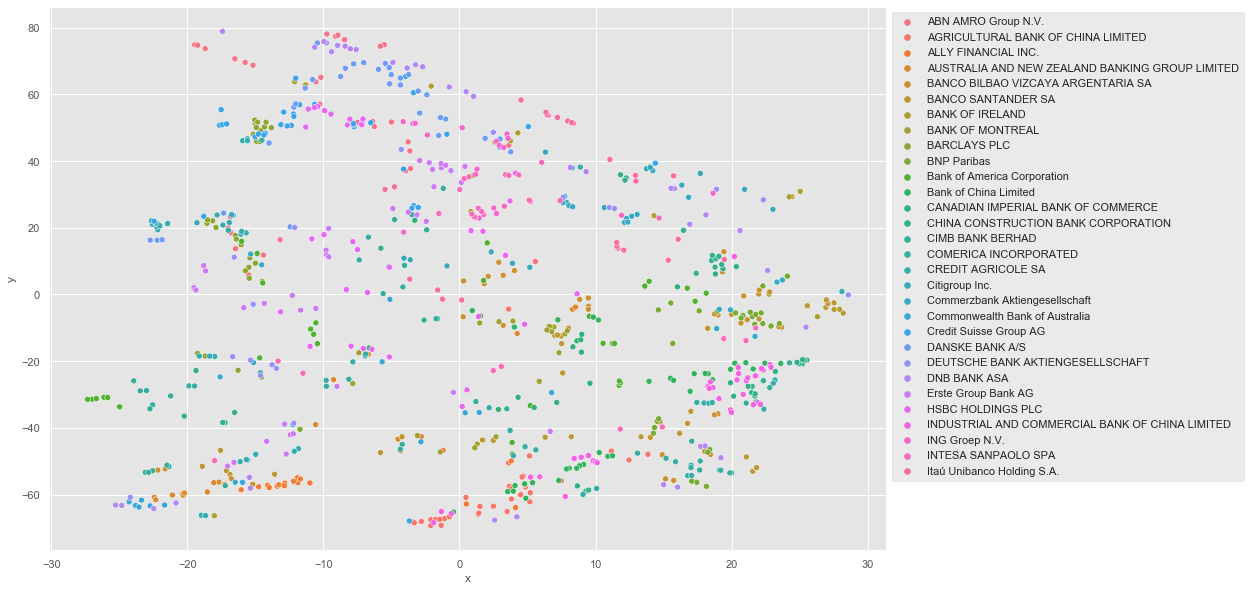

In [11]:
ctpy_short_list = list(df_train['desc'].unique())[:30]

plt.figure(figsize=(15,10))

df_plot = df_train.copy()
    
sns.scatterplot(x='x', y='y',hue='desc',data=df_plot[df_plot['desc'].map(lambda x : x in ctpy_short_list)])
plt.legend(bbox_to_anchor=(1, 1), loc=2)
plt.show()

In [12]:
print(feats)
print(len(df_train),len(df_train.dropna()))

len(df_train['y_rel'].dropna())

['Capital Adequacy Ratio1', 'Fully Loaded CET1 (%)1', 'ROAA1']
2074 2074


2074

In [13]:
df_train['desc'].unique()[66]

'The Bank of New York Mellon Corporation'

In [14]:
df_train[df_train['desc']=='The Bank of New York Mellon Corporation'].head()

indicator                                     desc     level_2  \
1803       The Bank of New York Mellon Corporation   6/30/2010   
1804       The Bank of New York Mellon Corporation   9/30/2010   
1805       The Bank of New York Mellon Corporation  12/31/2010   
1806       The Bank of New York Mellon Corporation   3/31/2011   
1807       The Bank of New York Mellon Corporation   6/30/2011   

indicator  Capital Adequacy Ratio1  Fully Loaded CET1 (%)1     ROAA1  idx  \
1803                         17.21                   11.86  0.797023  1.0   
1804                         15.76                   10.67  1.065134  2.0   
1805                         16.32                   11.75  1.083081  3.0   
1806                         16.76                   12.36  1.054967  4.0   
1807                         16.67                   12.56  1.068499  5.0   

indicator  Capital Adequacy Ratio1T1  Capital Adequacy Ratio1_rel  \
1803                           17.19                     0.001163   
1804                           17.21                    -0.084253   
1805                           15.76                     0.035533   
1806                           16.32                     0.026961   
1807                           16.76                    -0.005370   

indicator  Fully Loaded CET1 (%)1T1  Fully Loaded CET1 (%)1_rel   ROAA1T1  \
1803                          11.62                    0.020654  0.555189   
1804                          11.86                   -0.100337  0.797023   
1805                          10.67                    0.101218  1.065134   
1806                          11.75                    0.051915  1.083081   
1807                          12.36                    0.016181  1.054967   

indicator  ROAA1_rel         x          y      x_rel      y_rel  
1803        0.435589 -8.146741  16.752321  73.807037   3.610452  
1804        0.336391 -4.774005  -2.003938  66.380630   0.789070  
1805        0.016849 -2.807422   8.225530   3.218536  26.124439  
1806       -0.025957 -1.368829  18.636034  -6.222001  20.246243  
1807        0.012826  0.208793  18.953222   3.383343  -6.343385

## 4. Outlier Detection processing

We use an algorithm called Local Outlier Factor, pulled from the machine learning library Scikit Learn. You can find more information about local outlier factor [here](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html) and also [here](https://en.wikipedia.org/wiki/Local_outlier_factor)

In [15]:
from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor(n_neighbors=30)
df_train['outliers'] = clf.fit_predict(df_train[[feat+'_rel' for feat in feats]].values)

/opt/miniconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


In [17]:
df_train=df_train[df_train['ROAA1_rel']>-300]
df_train.head() #-1 means outlier

indicator                 desc    level_2  Capital Adequacy Ratio1  \
0          ABN AMRO Group N.V.  3/31/2011                17.869579   
1          ABN AMRO Group N.V.  6/30/2011                18.151743   
2          ABN AMRO Group N.V.  9/30/2011                17.382323   
3          ABN AMRO Group N.V.  3/31/2012                16.508374   
4          ABN AMRO Group N.V.  6/30/2012                16.213218   

indicator  Fully Loaded CET1 (%)1     ROAA1  idx  Capital Adequacy Ratio1T1  \
0                       11.351277  0.564036  4.0                  16.621965   
1                       11.415061  0.397196  5.0                  17.869579   
2                       10.857577  0.160774  6.0                  18.151743   
3                       10.621552  0.348426  8.0                  16.787278   
4                       11.852388  0.285924  9.0                  16.508374   

indicator  Capital Adequacy Ratio1_rel  Fully Loaded CET1 (%)1T1  \
0                             0.075058                 10.387869   
1                             0.015790                 11.351277   
2                            -0.042388                 11.415061   
3                            -0.016614                 10.656375   
4                            -0.017879                 10.621552   

indicator  Fully Loaded CET1 (%)1_rel   ROAA1T1  ROAA1_rel          x  \
0                            0.092744  0.035946  14.691255 -16.791634   
1                            0.005619  0.564036  -0.295797 -17.002676   
2                           -0.048838  0.397196  -0.595228 -16.449175   
3                           -0.003268  0.062759   4.551824 -15.482994   
4                            0.115881  0.348426  -0.179386   5.581356   

indicator          y      x_rel      y_rel  outliers  
0          18.502052  97.450737 -20.219398        -1  
1          19.920330 -64.784302   2.239021         1  
2          13.731059 -81.097031  -0.349012         1  
3           5.819563  93.910126 -22.019058        -1  
4           9.899541 -55.272747   9.925229        -1

## 5. Results

The results below consists of 3 scatter plots, representing one on one 2 dimensional data points for the 3 features. Dots in red represent the outliers and in blue the non-outliers. The big dot on the left sides is a manually identified outlier, corresponding to a accounting regulatory change for Bank of New York in 2014.

<Figure size 1080x720 with 0 Axes>

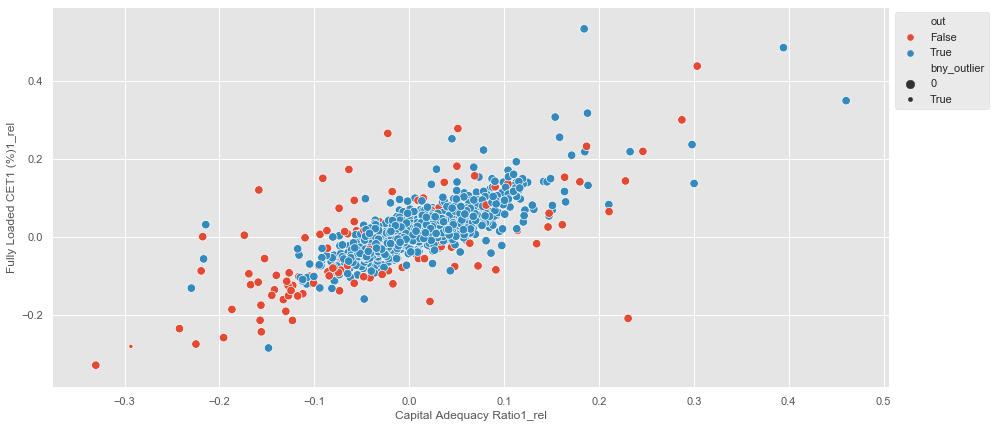

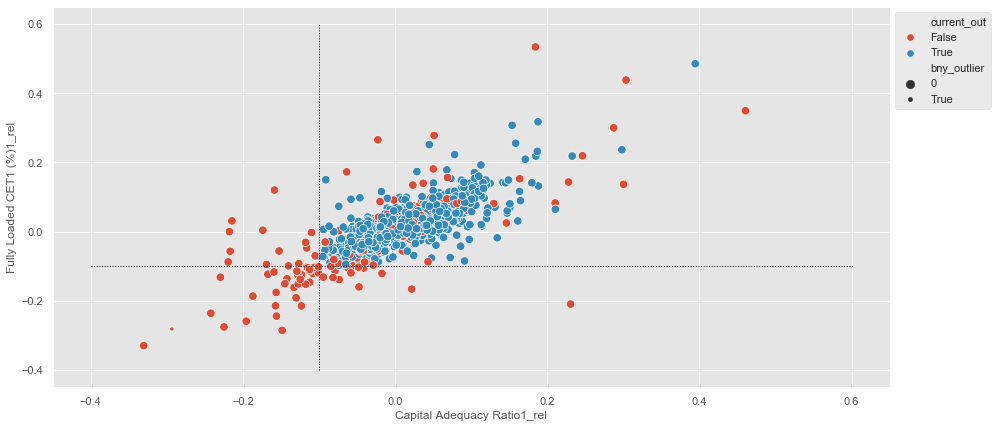

In [18]:

ctpy_short_list = list(df_train['desc'].unique())[:300]

plt.figure(figsize=(15,10))

df_plot = df_train.copy()
#df_plot = df_train[df_train['desc']=='The Bank of New York Mellon Corporation'].copy()
ctpy = list(df_train['desc'].unique())[66]

def is_ctp(ctp):
    if ctp == ctpy: return ctpy
    return 'other'

def is_bny(row):
    if (row['idx'] == 17 and row['desc'] in ['The Bank of New York Mellon Corporation']) : return True
    return 0

def current_out(row):
    if ((row['ROAA1_rel'] < -0.2) or (row['Capital Adequacy Ratio1_rel'] < -0.1) or (row['Fully Loaded CET1 (%)1_rel'] < -0.1) ) : return False
    return True

def out(row):
    if (row['outliers']<1 and (min(row['ROAA1_rel'],row['Capital Adequacy Ratio1_rel'],\
                                 row['Fully Loaded CET1 (%)1_rel'] )< -0.05 )) : return False
    return True


df_plot['ctp']=df_plot['desc'].map(is_ctp)
df_plot['bny_outlier']=df_plot.apply(is_bny,axis=1)
#df_plot['out']=df_plot['outliers']>0.5
df_plot['current_out']=df_plot.apply(current_out,axis=1)
df_plot['out']=df_plot.apply(out,axis=1)

#sns.scatterplot(x='idx', y='Capital Adequacy Ratio1',hue='desc',size='idx', data=df_plot[df_plot['desc'].map(lambda x : x in ctpy_short_list)])

'''for i in range(len(feats)) :
    for j in range(len(feats)) :
        if j> i :
            feat1 = feats[i]
            feat2 = feats[j]
            plt.figure(figsize=(15,10))
            ax = sns.scatterplot(x=feat1+'_rel', y=feat2+'_rel',hue='out',size='bny_outlier',data=df_plot[df_plot['desc'].map(lambda x : x in ctpy_short_list)])
            plt.legend(bbox_to_anchor=(1, 1), loc=2)
            plt.show()'''


plt.figure(figsize=(15,7))        
sns.scatterplot(x='Capital Adequacy Ratio1_rel', y='Fully Loaded CET1 (%)1_rel',hue='out',size='bny_outlier',data=df_plot[df_plot['desc'].map(lambda x : x in ctpy_short_list)])

plt.legend(bbox_to_anchor=(1, 1), loc=2)
plt.show()

plt.figure(figsize=(15,7))        
#sns.scatterplot(x='x_rel', y='y_rel',hue='out',size='bny_outlier',data=df_plot[df_plot['UCI'].map(lambda x : x in ctpy_short_list)])
sns.scatterplot(x='Capital Adequacy Ratio1_rel', y='Fully Loaded CET1 (%)1_rel',hue='current_out',size='bny_outlier',data=df_plot[df_plot['desc'].map(lambda x : x in ctpy_short_list)])
plt.plot([-0.1, -0.1], [-0.4, 0.6], linewidth=1,color ='black',linestyle=':')
plt.plot([-0.4, 0.6],[-0.1, -0.1], linewidth=1,color ='black',linestyle=':')
plt.legend(bbox_to_anchor=(1, 1), loc=2)
plt.show()